In [1]:
from __future__ import print_function

import argparse
import csv
import os

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

#from utils import progress_bar

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [3]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
BATCH_SIZE = 4

In [6]:
trainset = datasets.CIFAR10(root='data/', train=True, download=True,
                            transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='data/', train=False, download=False,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

0it [00:00, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [7]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [8]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [9]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                       ALPHA, use_cuda)
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        train_loss += loss.item()
        #train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch %10 == 0:
            print(batch_idx, len(trainloader),
                         'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                            100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)

In [10]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        with torch.no_grad():
            outputs = net(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        #test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        if epoch % 10 == 0:
            print(batch_idx, len(testloader),
                         'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total,
                            correct, total))
    acc = 100.*correct/total
    if epoch == start_epoch + total_epoch - 1 or acc > best_acc:
        checkpoint(acc, epoch)
    if acc > best_acc:
        best_acc = acc
    return (test_loss/batch_idx, 100.*correct/total)

In [11]:
def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = LEARNING_RATE
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [12]:
def checkpoint(acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net,
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + 'cifar_lenet_' + str(SEED))

In [13]:
SEED = 42
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
torch.manual_seed(SEED)
total_epoch = 200
LEARNING_RATE = 0.1

In [14]:
net = LeNet()

In [15]:
img, lbl = next(iter(trainloader))

In [16]:
net(img).shape

torch.Size([4, 10])

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

In [18]:
logname = ('results/log_' + net.__class__.__name__ + '_' + 'cifar_lenet_' + str(SEED) + '.csv')

In [19]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [20]:
inputs, targets = next(iter(trainloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


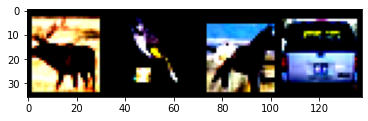

In [21]:
show_batch(inputs)

In [22]:
targets

tensor([4, 2, 7, 1])

In [32]:
ALPHA = 0.2

In [33]:
mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, ALPHA, use_cuda)
lam

0.3334581537481556

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


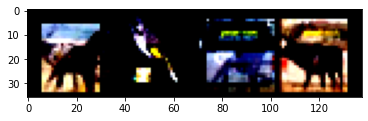

In [34]:
show_batch(mixed_inputs)